## CareerCon 2019 — Help Navigate Robots
## Junfei Ma
## https://www.kaggle.com/c/career-con-2019/

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
import lightgbm as lgb
sns.set()

In [2]:
X_train_df = pd.read_csv("X_train.csv")
X_test_df = pd.read_csv("X_test.csv")
Y_train_df = pd.read_csv("y_train.csv")
sub = pd.read_csv("sample_submission.csv")

# Data exploration

In [3]:
X_train_df.shape, Y_train_df.shape , X_test_df.shape

((487680, 13), (3810, 3), (488448, 13))

In [4]:
X_train_df.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003386,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [5]:
Y_train_df.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


In [6]:
X_test_df.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,0.91208,-0.38193,-0.050618,0.14028,-0.060205,0.071286,-0.18787,0.29492,2.8027,-9.6816
1,0_1,0,1,0.91220,-0.38165,-0.050573,0.14028,-0.033486,0.060210,-0.18206,0.14944,2.5408,-9.8521
2,0_2,0,2,0.91228,-0.38143,-0.050586,0.14032,-0.029686,0.029476,-0.18441,-0.49741,2.5853,-9.3835
3,0_3,0,3,0.91237,-0.38121,-0.050588,0.14035,-0.024217,0.037788,-0.18783,-0.32376,2.9966,-8.7415
4,0_4,0,4,0.91247,-0.38096,-0.050546,0.14042,-0.038047,0.083405,-0.20170,-0.70103,2.6498,-8.8432


### Check missing data

In [7]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [8]:
missing_data(X_train_df)

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
Total,0,0,0,0,0,0,0,0,0,0,0,0,0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Types,object,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [9]:
missing_data(X_test_df)

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
Total,0,0,0,0,0,0,0,0,0,0,0,0,0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Types,object,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [10]:
missing_data(Y_train_df)

,series_id,group_id,surface
Total,0,0,0
Percent,0.0,0.0,0.0
Types,int64,int64,object


In [11]:
X_train_df.describe()

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000
mean,1904.500000,63.500000,-0.018050,0.075062,0.012458,-0.003804,0.000178,0.008338,-0.019184,0.129281,2.886468,-9.364886
std,1099.853353,36.949327,0.685696,0.708226,0.105972,0.104299,0.117764,0.088677,0.229153,1.870600,2.140067,2.845341
min,0.000000,0.000000,-0.989100,-0.989650,-0.162830,-0.156620,-2.371000,-0.927860,-1.268800,-36.067000,-121.490000,-75.386000
25%,952.000000,31.750000,-0.705120,-0.688980,-0.089466,-0.106060,-0.040752,-0.033191,-0.090743,-0.530833,1.957900,-10.193000
50%,1904.500000,63.500000,-0.105960,0.237855,0.031949,-0.018704,0.000084,0.005412,-0.005335,0.124980,2.879600,-9.365300
75%,2857.000000,95.250000,0.651803,0.809550,0.122870,0.097215,0.040527,0.048068,0.064604,0.792262,3.798800,-8.522700
max,3809.000000,127.000000,0.989100,0.988980,0.155710,0.154770,2.282200,1.079100,1.387300,36.797000,73.008000,65.839000


In [12]:
X_test_df.describe()

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000
mean,1907.500000,63.500000,0.031996,0.120651,0.018735,0.004024,0.000401,0.013669,-0.036101,0.125433,2.906588,-9.359811
std,1101.585403,36.949327,0.671977,0.714522,0.108481,0.100957,0.114485,0.089440,0.233791,1.832639,2.094727,2.802670
min,0.000000,0.000000,-0.989720,-0.989810,-0.154680,-0.156270,-2.403300,-1.193000,-1.458200,-35.040000,-107.480000,-83.173000
25%,953.750000,31.750000,-0.648130,-0.744503,-0.112660,-0.098434,-0.037396,-0.029865,-0.089843,-0.486233,2.052100,-10.125000
50%,1907.500000,63.500000,0.132910,0.397860,0.057271,0.022654,0.001107,0.007276,-0.008911,0.112490,2.900300,-9.361700
75%,2861.250000,95.250000,0.575270,0.803600,0.124770,0.083706,0.037827,0.051112,0.057876,0.727250,3.758000,-8.582075
max,3815.000000,127.000000,0.989320,0.988940,0.154250,0.152510,3.396600,1.150700,0.960280,36.628000,55.624000,59.633000


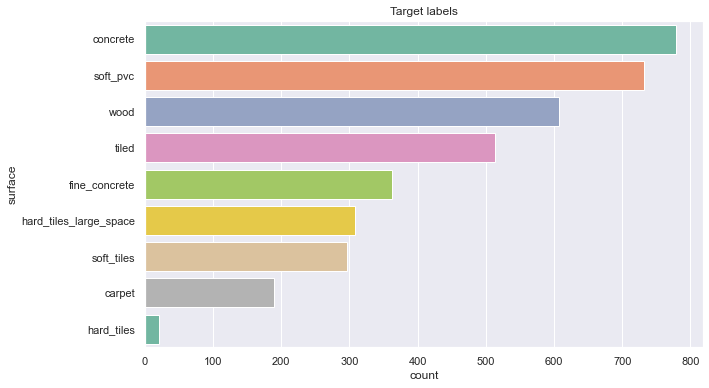

In [13]:
plt.figure(figsize=(10,6))
plt.title("Target labels")
sns.countplot(y='surface', data = Y_train_df, order = Y_train_df['surface'].value_counts().index,  palette="Set2")
plt.show()

The data is unbalanced! 

# Feature extraction

In [14]:
from scipy.stats import kurtosis
from scipy.stats import skew

def _kurtosis(x):
    return kurtosis(x)

def CPT5(x):
    den = len(x)*np.exp(np.std(x))
    return sum(np.exp(x))/den

def skewness(x):
    return skew(x)

def SSC(x):
    x = np.array(x)
    x = np.append(x[-1], x)
    x = np.append(x,x[1])
    xn = x[1:len(x)-1]
    xn_i2 = x[2:len(x)]    # xn+1 
    xn_i1 = x[0:len(x)-2]  # xn-1
    ans = np.heaviside((xn-xn_i1)*(xn-xn_i2),0)
    return sum(ans[1:]) 

def wave_length(x):
    x = np.array(x)
    x = np.append(x[-1], x)
    x = np.append(x,x[1])
    xn = x[1:len(x)-1]
    xn_i2 = x[2:len(x)]    # xn+1 
    return sum(abs(xn_i2-xn))
    
def norm_entropy(x):
    tresh = 3
    return sum(np.power(abs(x),tresh))

def SRAV(x):    
    SRA = sum(np.sqrt(abs(x)))
    return np.power(SRA/len(x),2)

def mean_abs(x):
    return sum(abs(x))/len(x)

def zero_crossing(x):
    x = np.array(x)
    x = np.append(x[-1], x)
    x = np.append(x,x[1])
    xn = x[1:len(x)-1]
    xn_i2 = x[2:len(x)]    # xn+1
    return sum(np.heaviside(-xn*xn_i2,0))


In [15]:
def feature_extraction(raw_frame):
    frame = pd.DataFrame()
    raw_frame['angular_velocity'] = raw_frame['angular_velocity_X'] + raw_frame['angular_velocity_Y'] + raw_frame['angular_velocity_Z']
    raw_frame['linear_acceleration'] = raw_frame['linear_acceleration_X'] + raw_frame['linear_acceleration_Y'] + raw_frame['linear_acceleration_Z']
    raw_frame['velocity_to_acceleration'] = raw_frame['angular_velocity'] / raw_frame['linear_acceleration']
    
    for col in raw_frame.columns[3:]:
        frame[col + '_mean'] = raw_frame.groupby(['series_id'])[col].mean()        
        frame[col + '_CPT5'] = raw_frame.groupby(['series_id'])[col].apply(CPT5) 
        frame[col + '_SSC'] = raw_frame.groupby(['series_id'])[col].apply(SSC) 
        frame[col + '_skewness'] = raw_frame.groupby(['series_id'])[col].apply(skewness)
        frame[col + '_wave_lenght'] = raw_frame.groupby(['series_id'])[col].apply(wave_length)
        frame[col + '_norm_entropy'] = raw_frame.groupby(['series_id'])[col].apply(norm_entropy)
        frame[col + '_SRAV'] = raw_frame.groupby(['series_id'])[col].apply(SRAV)
        frame[col + '_kurtosis'] = raw_frame.groupby(['series_id'])[col].apply(_kurtosis) 
        frame[col + '_mean_abs'] = raw_frame.groupby(['series_id'])[col].apply(mean_abs) 
        frame[col + '_zero_crossing'] = raw_frame.groupby(['series_id'])[col].apply(zero_crossing) 
    return frame

In [16]:
train_df = feature_extraction(X_train_df)
test_df = feature_extraction(X_test_df)

<ipython-input-14-eda776cc1812>:8: RuntimeWarning: overflow encountered in exp
  den = len(x)*np.exp(np.std(x))


In [17]:
train_df.head()

,orientation_X_mean,orientation_X_CPT5,orientation_X_SSC,orientation_X_skewness,orientation_X_wave_lenght,orientation_X_norm_entropy,orientation_X_SRAV,orientation_X_kurtosis,orientation_X_mean_abs,orientation_X_zero_crossing,...,velocity_to_acceleration_mean,velocity_to_acceleration_CPT5,velocity_to_acceleration_SSC,velocity_to_acceleration_skewness,velocity_to_acceleration_wave_lenght,velocity_to_acceleration_norm_entropy,velocity_to_acceleration_SRAV,velocity_to_acceleration_kurtosis,velocity_to_acceleration_mean_abs,velocity_to_acceleration_zero_crossing
series_id,,,,,,,,,,,,,,,,,,,,,
0,-0.758666,0.468122,11.0,-0.651333,0.00292,55.893558,0.758666,-0.667740,0.758666,0.0,...,-0.000748,0.986734,63.0,-2.219887,1.052930,0.001020,0.006071,19.726029,0.007851,36.0
1,-0.958606,0.383369,22.0,-0.392618,0.00330,112.753747,0.958606,-0.664664,0.958606,0.0,...,-0.000794,0.909120,58.0,4.347738,4.943778,1.004801,0.016668,62.169640,0.029200,32.0
2,-0.512057,0.598440,10.0,0.150184,0.01008,17.186012,0.512056,-1.058422,0.512057,0.0,...,-0.008090,0.956615,63.0,-7.962085,2.082183,0.055787,0.010199,76.708902,0.014909,32.0
3,-0.939169,0.390864,22.0,-0.094976,0.00368,106.033081,0.939169,-1.082946,0.939169,0.0,...,0.082630,27.228217,63.0,10.192253,32.004173,723.390366,0.043462,107.819910,0.138407,42.0
4,-0.891301,0.408918,1.0,-0.224035,0.02032,90.635160,0.891298,-1.167403,0.891301,0.0,...,0.014863,1.004595,47.0,0.389773,0.591386,0.001087,0.013491,0.434631,0.015326,6.0


In [18]:
train_df.shape, test_df.shape

((3810, 130), (3816, 130))

Fix -inf, +inf and NaN

In [19]:

train_df.fillna(0, inplace = True)
train_df.replace(-np.inf, 0, inplace = True)
train_df.replace(np.inf, 0, inplace = True)
test_df.fillna(0, inplace = True)
test_df.replace(-np.inf, 0, inplace = True)
test_df.replace(np.inf, 0, inplace = True)

Standarization

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(train_df))
X_test_scaled = pd.DataFrame(scaler.transform(test_df))

C:\Users\josep\anaconda3\lib\site-packages\sklearn\utils\extmath.py:1066: RuntimeWarning: overflow encountered in square
  temp **= 2
C:\Users\josep\anaconda3\lib\site-packages\sklearn\utils\extmath.py:1072: RuntimeWarning: overflow encountered in square
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\josep\anaconda3\lib\site-packages\sklearn\utils\extmath.py:1072: RuntimeWarning: invalid value encountered in subtract
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\josep\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:86: RuntimeWarning: overflow encountered in square
  upper_bound = n_samples * eps * var + (n_samples * mean * eps) ** 2


# LightGBM classifier 

In [21]:
le = LabelEncoder()
target = le.fit_transform(Y_train_df['surface'])

In [22]:
params = {
    'num_leaves': 54,
    'min_data_in_leaf': 40,
    'objective': 'multiclass',
    'max_depth': 8,
    'learning_rate': 0.01,
    "boosting": "gbdt",
    "bagging_freq": 5,
    "bagging_fraction": 0.8126672064208567,
    "bagging_seed": 11,
    "verbosity": -1,
    'reg_alpha': 0.1302650970728192,
    'reg_lambda': 0.3603427518866501,
    "num_class": 9,
    'nthread': -1
}

def multiclass_accuracy(preds, train_data):
    labels = train_data.get_label()
    pred_class = np.argmax(preds.reshape(9, -1).T, axis=1)
    return 'multi_accuracy', np.mean(labels == pred_class), True


train_set = lgb.Dataset(X_train_scaled, label=target)
eval_hist = lgb.cv(params, train_set, nfold=10, num_boost_round=9999,
                   early_stopping_rounds=100, seed=19, feval=multiclass_accuracy)
num_rounds = len(eval_hist['multi_logloss-mean'])

# retrain the model and make predictions for test set
clf = lgb.train(params, train_set, num_boost_round=num_rounds)
predictions = clf.predict(X_test_scaled, num_iteration=None)


C:\Users\josep\anaconda3\lib\site-packages\lightgbm\engine.py:577: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


The following plots show the mean logloss and accuracy at each iteration (blue line). The red lines are the standard deviation between folds.

Validation logloss: 0.3366, accuracy: 0.8858


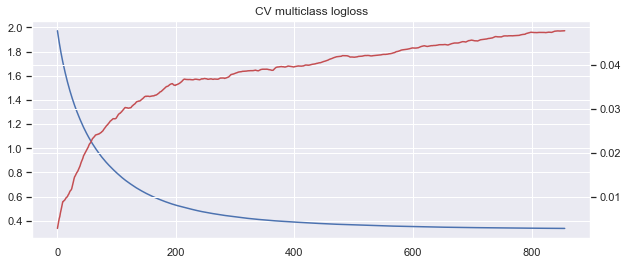

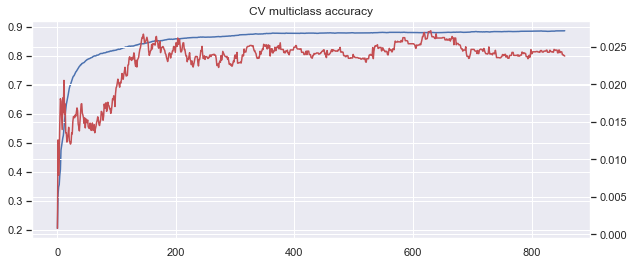

In [23]:
v1, v2 = eval_hist['multi_logloss-mean'][-1], eval_hist['multi_accuracy-mean'][-1]
print("Validation logloss: {:.4f}, accuracy: {:.4f}".format(v1, v2))
plt.figure(figsize=(10, 4))
plt.title("CV multiclass logloss")
num_rounds = len(eval_hist['multi_logloss-mean'])
ax = sns.lineplot(x=range(num_rounds), y=eval_hist['multi_logloss-mean'])
ax2 = ax.twinx()
p = sns.lineplot(x=range(num_rounds), y=eval_hist['multi_logloss-stdv'], ax=ax2, color='r')

plt.figure(figsize=(10, 4))
plt.title("CV multiclass accuracy")
num_rounds = len(eval_hist['multi_accuracy-mean'])
ax = sns.lineplot(x=range(num_rounds), y=eval_hist['multi_accuracy-mean'])
ax2 = ax.twinx()
p = sns.lineplot(x=range(num_rounds), y=eval_hist['multi_accuracy-stdv'], ax=ax2, color='r') 

### LGBM submission

In [24]:
sub['surface'] = le.inverse_transform(predictions.argmax(axis=1))
sub.to_csv('submission_lgbm.csv', index=False)